# Appendix of additional (secondary) code.
- Testing utility functions
- Secondary numerical exploratioins

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from collections import namedtuple
from scipy import linalg
import utils

# Is my covariance ellipse implementation correct?

Compare my implementation to matplotlib's implementation.

In [4]:
# The matplotlib implementation.
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

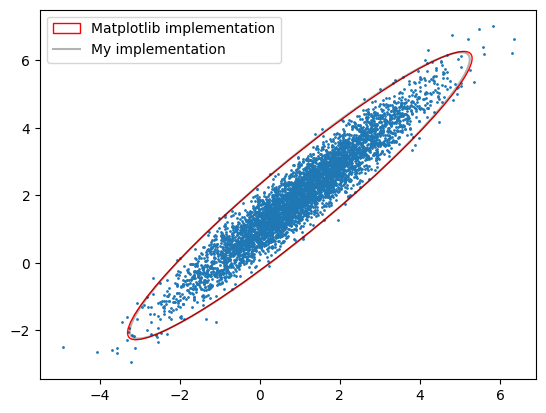

My implementation matches that of matplotlib's example code


In [5]:
# Visually show both implementations produce the same confidence ellipse
mu = np.array([1,2])
S = np.array([[2., 1.9], [1.9, 2]])

data = np.random.multivariate_normal(mu, S, size=5000)
x = data[:,0]
y = data[:,1]

fig, ax = plt.subplots()
ax.scatter(x,y,s=1)
confidence_ellipse(x, y, ax, n_std=3.0, edgecolor='red', label='Matplotlib implementation')
utils.plot_covar_ellipse(S, mu, mult=3.0, label='My implementation')
plt.legend()
plt.show()

print('My implementation matches that of matplotlib\'s example code')

# Is a given point inside a covariance ellipse?

Demonstrate my utility function that determines if a given 2D point $\vec{p}$ is in the closure of a given confidence ellipse centered at $\mu$ with semi-major axis $r_1$, semi-minor axis $r_2$. ($r_1 = \alpha \sqrt{\lambda_1}$ and $r_2 = \alpha \sqrt{\lambda_2}$ where $\alpha$ scales the number of standard deviations we wish the ellipse to visualize)

If

$\left(\frac{cos(\theta)(p_x-\mu_x)+sin(\theta)(p_y-\mu_y)}{r_1}\right)^2 + \left(\frac{sin(\theta)(p_x-\mu_x)-cos(\theta)(p_y-\mu_y)}{r_2}\right)^2 \leq 1$

Then $\vec{p}$ is inside the ellipse.

TODO: CITE
- https://stackoverflow.com/questions/7946187/point-and-ellipse-rotated-position-test-algorithm
- https://cookierobotics.com/007/

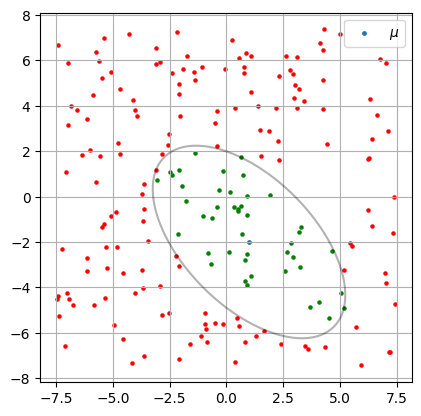

In [6]:
# Define our ellipse
mu = np.array([1,-2])
S = np.array([[2., -1.1], [-1.1, 2]])

# Generate uniform random test points
x_lim = 15.0
points = np.random.random((200, 2)) * x_lim - np.array([x_lim/2, x_lim/2])

fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.scatter(mu[0], mu[1] , s=6, label=r'$\mu$')
utils.plot_covar_ellipse(S, mu, mult=3.0)

# Test if our test points are inside the ellipse
for p in points:
    color = 'green' if utils.ellipse_contains(p, mu, S, n_std=3) else 'red'
    ax.scatter(p[0], p[1], s=5, color=color)

#assert ellipse_contains(p, mu, S, n_std=3)
plt.legend()
plt.grid()
plt.show()

(bayesian-1d-kalman)=
# Bayesian Style Implementation of 1D Kalman Filter

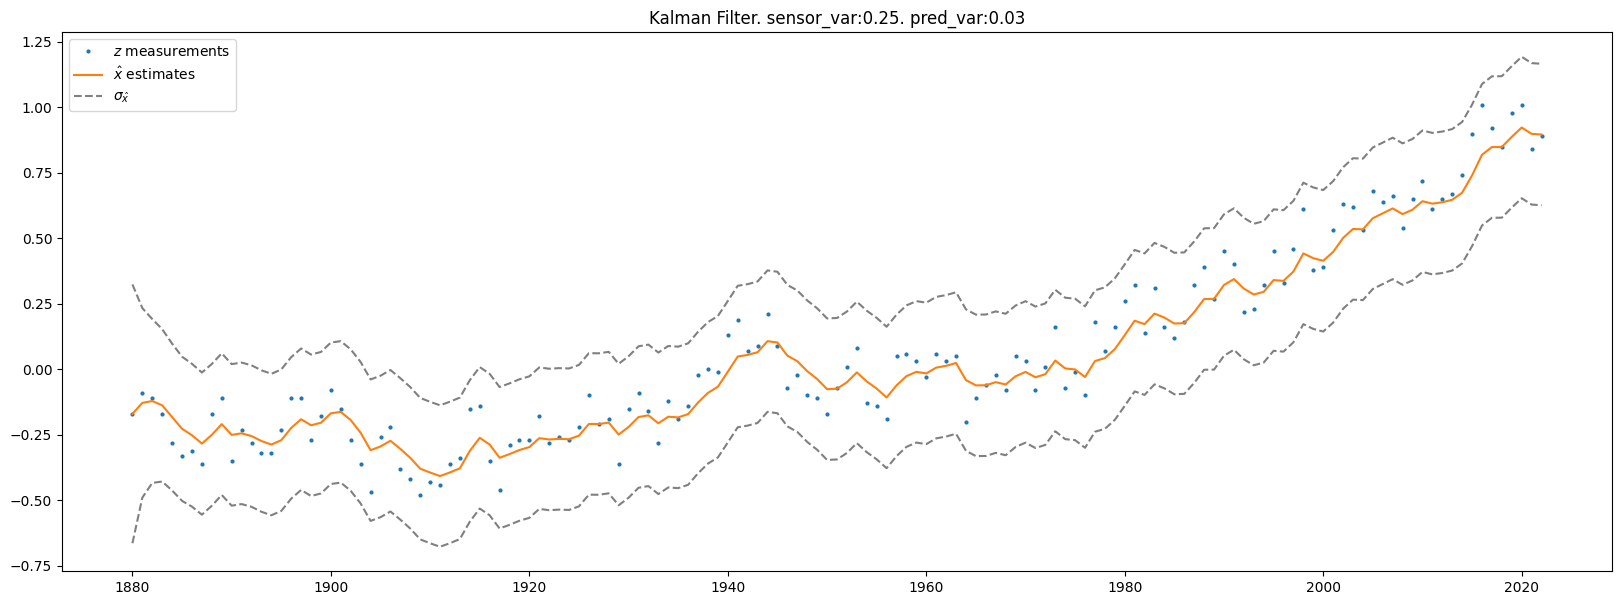

Estimate variance


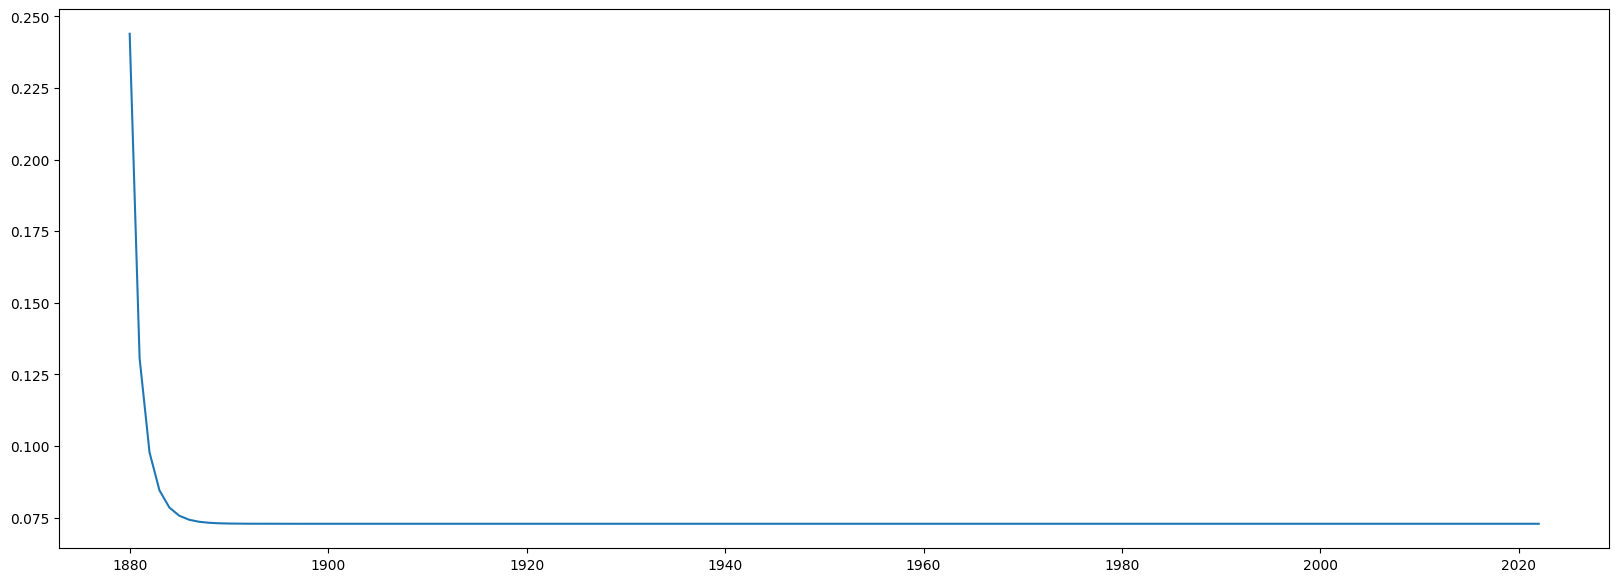

In [13]:
# Named tuples to represent gaussian distributions
Gauss = namedtuple('Gauss', 'mean var')

df = pd.read_csv('temp_anomalies.csv')
pred_var = 0.03
sensor_var = 0.25

# Measurements
zs = df.no_smoothing

# Initialize system and filter state
# Prior
x_hat = Gauss(zs[0], 10) # Initialize estimate to first measurement value

x_hats = np.full(len(zs), np.nan)
x_hat_vars = np.full(len(zs), np.nan)

for i in range(len(zs)):
    z = zs[i]
    
    # Prediction step - via process model
    dx = Gauss(0, pred_var)
    prior = Gauss(x_hat.mean + dx.mean, x_hat.var + dx.var)
    
    # Update (correct the prediction - from prior to posterior)
    l = Gauss(z, sensor_var) # Likelihood of measurement
    post_mean = (prior.var * l.mean + l.var * prior.mean)/(prior.var + l.var)
    post_var = (prior.var * l.var) / (prior.var + l.var)
    x_hat = Gauss(post_mean, post_var)
    x_hats[i] = x_hat.mean
    x_hat_vars[i] = x_hat.var
    
    # Posterior becomes next iterations prior
    prior = x_hat
    
plt.rcParams["figure.figsize"] = (20,7)
plt.plot(df.year, df.no_smoothing, marker='o', linestyle='none', markersize=2, label=r'$z$ measurements')
plt.plot(df.year, x_hats, label=r'$\hat{x}$ estimates')
plt.plot(df.year, x_hats + np.sqrt(x_hat_vars), linestyle='dashed', color='gray', label='$\sigma_{\hat{x}}$')
plt.plot(df.year, x_hats - np.sqrt(x_hat_vars), linestyle='dashed', color='gray')
plt.title(f'Kalman Filter. sensor_var:{sensor_var}. pred_var:{pred_var}')
plt.legend()
plt.show()

print('Estimate variance')
plt.plot(df.year, x_hat_vars)
plt.show()